<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled181.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Cell UTSCdJjY54rw: Install necessary libraries.
!pip install qiskit-aer qiskit

# Cell 4D3O8FeZ55W8: This cell contains the core simulation logic, including the Protoribosome, Colony, and Environment classes, as well as the main orchestrator function to run the simulation.
import os
import sys
import numpy as np # Ensure numpy is imported at the very top
import pandas as pd
import random
import pickle
from datetime import datetime
from google.colab import output
from tqdm.notebook import tqdm
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import google.colab.drive as drive # Use the alias
import glob
import re

# ===================================================================
# === SIMULATION SETTINGS ===
# =================================================0=================

# --- Control Flag for Fresh Start vs. Resume ---
# Set to True to always start a new simulation from step 0.
# This will create a new experiment directory.
# Set to False to attempt to find and resume the latest checkpoint
# in the most recent experiment directory.
FORCE_FRESH_START = False # <--- CHANGE THIS TO True OR False ---
# -----------------------------------------------

# Define a base directory for experiments in Google Drive
BASE_EXPERIMENTS_PATH = '/content/drive/My Drive/Colab Notebooks/Sim_Experiments'

# Simulation parameters (can be adjusted)
NUM_REPLICAS = 1 # Number of independent simulation runs
STEPS_PER_DAY = 10 # Simulation steps per simulated day
MAX_RUN_STEPS = 10000 # Total simulation steps to run per replica
SAVE_INTERVAL = 500 # Save a checkpoint every this many steps
INITIAL_POP_SIZE = 2500 # Starting number of protoribosomes

# Original DNA template
ORIGINAL_DNA_TEMPLATE = "AUGUGUUACUGG"
# Length of random sequence to add (in amino acids)
RANDOM_AA_LENGTH = 33 # Changed from 100 to 33
RANDOM_NUCLEOTIDE_LENGTH = RANDOM_AA_LENGTH * 3


# ===================================================================
# === QUANTUM RANDOM GENERATOR ===
# ===================================================================

class QuantumRandomGenerator:
    def __init__(self, num_bits_precision=64):
        self.simulator = AerSimulator()
        self.num_bits = num_bits_precision

    def get_seed(self, entropy_input=None): # Added optional entropy_input
        qc = QuantumCircuit(self.num_bits, self.num_bits)
        qc.h(range(self.num_bits))
        # If entropy_input is provided, potentially use it to influence the circuit
        # For this simple example, we just measure
        qc.measure(range(self.num_bits), range(self.num_bits))
        job = self.simulator.run(transpile(qc, self.simulator), shots=1)
        # Get the result as a bit string and convert to integer
        result = job.result().get_counts(0)
        bitstring = list(result.keys())[0]
        return int(bitstring, 2)


# ===================================================================
# === ENVIRONMENT CLASS ===
# ===================================================================

class Environment:
    # Modified __init__ to accept optional pre-generated data
    def __init__(self, rng, days_per_cycle=10, uv_intensity=None, temperature=None):
        self.days_per_cycle, self.time, self.rng = days_per_cycle, 0, rng
        self.steps_per_year = 365 * self.days_per_cycle

        # If pre-generated data is provided, use it. Otherwise, generate new cycles.
        if uv_intensity is not None and temperature is not None:
            self.uv_intensity = uv_intensity
            self.temperature = temperature
            # print("--- Debug: Using provided environment data ---") # Debug print for clarity - commented out
        else:
            # Generate initial environment data for a fixed number of years (e.g., 50)
            # This ensures we have enough data even for very long simulations
            self._generate_cycles(num_years=50)
            # print("--- Debug: Generated new environment data ---") # Debug print for clarity - commented out


    def _generate_cycles(self, num_years):
        # Corrected typo: used self.steps_per_year
        total_steps = num_years * self.steps_per_year
        two_pi = 2 * np.pi # Calculate 2*pi separately
        # Ensure daily_uv_cycle has correct length
        daily_uv_cycle = np.sin(np.linspace(0, two_pi, self.days_per_cycle))
        daily_uv_cycle[daily_uv_cycle < 0] = 0 # UV cannot be negative

        # Ensure daily_temp_swing has correct length
        daily_temp_swing = -4 * np.cos(np.linspace(0, two_pi, self.days_per_cycle)) # Use the variable
        base_weather_noise = self.rng.standard_normal(total_steps)
        smoothing_window_size = 14 * self.days_per_cycle # Corrected smoothing window size
        smoothing_window = np.ones(smoothing_window_size) / smoothing_window_size
        weather_pattern = np.convolve(base_weather_noise, smoothing_window, 'same') * 5.0
        full_uv, full_temp = [], []
        global_step_counter = 0
        for _ in range(num_years):
            uv_severity = self.rng.uniform(0.6, 1.4)
            seasonal_temp_base = 15 - 10 * np.cos(np.linspace(0, two_pi, self.steps_per_year))
            seasonal_amplitude_mod = (0.225 * np.sin(np.linspace(0, two_pi, self.steps_per_year)) + 0.725) * uv_severity
            daily_temp_anomaly = 0
            for i in range(self.steps_per_year):
                if i % self.days_per_cycle == 0: daily_temp_anomaly = self.rng.uniform(-1.5, 1.5)
                cloud_cover_factor = self.rng.uniform(0.7, 1.0)
                # Use correct index for daily_uv_cycle and seasonal_amplitude_mod
                daily_uv = daily_uv_cycle[i % self.days_per_cycle] * seasonal_amplitude_mod[i] * cloud_cover_factor
                full_uv.append(daily_uv)
                solar_temp = seasonal_temp_base[i] + daily_temp_swing[i % self.days_per_cycle] + weather_pattern[global_step_counter] + daily_temp_anomaly
                full_temp.append(max(4.0, solar_temp))
                global_step_counter += 1
        # Store the generated cycles as attributes
        self.uv_intensity = np.array(full_uv)
        self.temperature = np.array(full_temp)

        # Add debugging print statements to check generated UV values
        # print("--- Debug: Generated UV Intensity Head and Tail ---") # Commented out debug print
        # print(self.uv_intensity[:10])
        # print(self.uv_intensity[-10:])
        # print("--------------------------------------------------")


    def get_current_uv(self):
        # Ensure environment data wraps around if simulation runs beyond generated years
        return self.uv_intensity[self.time % len(self.uv_intensity)]

    def get_current_temperature(self):
        # Ensure environment data wraps around if simulation runs beyond generated years
        return self.temperature[self.time % len(self.temperature)]

    def step(self):
        self.time += 1


# ===================================================================
# === PROTORIBOSOME CLASS ===
# ===================================================================

class Protoribosome:
    # Added colony parameter
    def __init__(self, env, colony, strategy, initial_sequence, rng, initial_mass=100.0):
        # Added self.colony
        self.env, self.colony, self.strategy, self.rna_sequence, self.rng = env, colony, strategy, list(initial_sequence), rng
        self.rna_mass = initial_mass
        self.uv_protection_pool = 50.0
        # Initialize damage level to 0.0
        self.rna_damage_level = 0.0
        self.location, self.status = 'shadow_zone', 'ACTIVE'
        # Removed individual nucleotide pools
        # self.nmp_pool = {'A': 100, 'U': 100, 'G': 100, 'C': 100}
        # self.ndp_pool = {'A': 50,  'U': 50,  'G': 50,  'C': 50}
        # self.ntp_pool = {'A': 20,  'U': 20,  'G': 20,  'C': 20}

        # Added peptide production status
        self.peptide_status = 'Unknown' # Can be 'Functional 4-mer', 'Mutant Peptide', 'Failed Production'


        # Modified: Set uv_damage_rate_per_uv to a higher value to encourage damage accumulation
        self.uv_damage_rate_per_uv = 0.1 # Reduced from 5.0, still higher than 1.0
        self.base_damage_rate = 0.01 # Added base damage rate

        self.repair_rate = 0.05 # Adjusted repair rate
        self.uv_protection_factor = 0.01
        self.damage_tolerance_threshold = 3.0
        self.mutation_prob = 0.001 # Reduced mutation probability

        # Track mutations, especially damaged Trp codons (UGG)
        self.mutated_bases = {} # Stores position: original_base for tracking
        self.damaged_bases = {} # Stores position: True for tracking
        self.damaged_trp_codon_count = 0 # Count of UGG codons with at least one damaged base


    def calculate_protection_score(self):
        score = (len(self.rna_sequence) // 3) * 0.1
        weights = {'UGG':5.0,'UAU':3.0,'UAC':3.0,'UUU':1.5,'UUC':1.5,'UGU':1.0,'UGC':1.0,'AUG':0.75,'CAU':0.5,'CAC':0.5}
        score += sum(weights.get("".join(self.rna_sequence[i:i+3]), 0) for i in range(0, len(self.rna_sequence), 3))
        return score

    def has_stop_codon(self):
        # Check for standard stop codons in the current sequence
        return any("".join(self.rna_sequence[i:i+3]) in {'UAA','UAG','UGA'} for i in range(0, len(self.rna_sequence), 3))

    def is_damaged_trp_codon(self):
        # Check for UGG codons that have at least one damaged base
        damaged_trp_count = 0
        for i in range(0, len(self.rna_sequence) - 2, 3): # Iterate through codons
            codon = "".join(self.rna_sequence[i:i+3])
            if codon == 'UGG':
                # Check if any base in this codon is marked as damaged
                if any(pos in self.damaged_bases for pos in range(i, i+3)):
                    damaged_trp_count += 1
        self.damaged_trp_codon_count = damaged_trp_count # Update internal count
        return damaged_trp_count > 0 # Return True if any damaged Trp codon exists


    # Modified to interact with Colony's shared pools and consider temperature
    # Added effective_uv parameter
    def _forage_and_phosphorylate(self, current_uv, current_temp, effective_uv):
        # Foraging rate can depend on temperature (higher temp, faster foraging)
        foraging_rate = 5.0 + (current_temp - 15.0) * 0.1 # Base rate 5, increases slightly with temp > 15

        # Add NMPs directly to the Colony's shared pool (rate adjusted by temp)
        for base in self.colony.shared_nmp_pool:
            # Add a varying amount based on foraging_rate and some noise
            # Use self.rng for noise specific to this protoribosome
            amount_to_add = max(0, int(self.rng.normal(foraging_rate, foraging_rate * 0.2))) # Add some variation
            self.colony.shared_nmp_pool[base] += amount_to_add

        # Phosphorylation efficiency can depend on temperature (optimal range)
        # This is a simplified model; real biological processes are complex.
        # Assume an optimal temperature around 25C, efficiency drops off outside this
        temp_effect_phos = max(0.1, 1.0 - abs(current_temp - 25.0) * 0.05) # Efficiency decreases as temp moves from 25C

        # Phosphorylation: NMP to NDP (from shared pool)
        # Attempt to convert a temperature-dependent amount if available
        nmp_to_ndp_attempt = max(1, int(5 * temp_effect_phos)) # Try to convert more if temperature is optimal
        for base in self.colony.shared_nmp_pool:
            # Check if there are enough NMPs in the shared pool
            can_convert = min(self.colony.shared_nmp_pool[base], nmp_to_ndp_attempt)
            if can_convert > 0:
                self.colony.shared_ndp_pool[base] += can_convert
                self.colony.shared_nmp_pool[base] -= can_convert # Corrected order of subtraction

        # Phosphorylation: NDP to NTP (from shared pool, energy-dependent)
        # Energy available for this step depends on UV protection and *effective UV*
        # This models UV driving phosphorylation, but protection reduces its harmful effects
        energy_available = self.uv_protection_pool * effective_uv * 0.1 # effective_uv defined in step()
        # Energy cost per conversion is 5
        ndp_to_ntp_conversions_possible = int(energy_available / 5)
        # Check total available NDPs in the shared pool
        total_available_ndp = sum(self.colony.shared_ndp_pool.values())
        ndp_to_ntp_conversions = min(ndp_to_ntp_conversions_possible, total_available_ndp) # Don't convert more than available shared NDPs

        if ndp_to_ntp_conversions > 0:
            # Randomly select NDPs from the shared pool to convert to NTPs
            available_ndp_bases = [base for base, count in self.colony.shared_ndp_pool.items() if count > 0]
            if available_ndp_bases:
                # Use self.rng for random choice within Protoribosome
                for _ in range(ndp_to_ntp_conversions):
                    chosen_base = self.rng.choice(available_ndp_bases)
                    if self.colony.shared_ndp_pool[chosen_base] > 0:
                        self.colony.shared_ndp_pool[chosen_base] -= 1
                        self.colony.shared_ntp_pool[chosen_base] += 1
                    # Re-check available bases in case shared pool is depleted during conversion
                    available_ndp_bases = [base for base, count in self.colony.shared_ndp_pool.items() if count > 0]


    # Modified to interact with Colony's shared pools and consume NTPs
    def _replicate_rna(self):
        # Replication requires ACTIVE status and sufficient mass for initial replication
        # Mass requirement should be a ratio of potential offspring mass, not absolute
        # For simplicity, let's say replication is possible if there's enough material (NTPs)
        # and the protoribosome is in a state to replicate (ACTIVE).
        if self.status != 'ACTIVE':
            return None

        # Calculate required NTPs from the shared pool to synthesize *a second copy* of the RNA sequence
        required_ntps = {base: self.rna_sequence.count(base) for base in 'AUGC'}
        required_ntps_for_doubling = {base: count for base, count in required_ntps.items()} # Needs enough for another copy

        # Check if sufficient NTPs are available in the shared pool for doubling/replication
        if not all(self.colony.shared_ntp_pool.get(base, 0) >= count for base, count in required_ntps_for_doubling.items()):
            # Replication fails if not enough shared NTPs for doubling
            # Optionally, log this failure for analysis
            # print("Replication failed: Insufficient shared shared_ntps_pool") # Commented out for cleaner output
            return None

        # Consume the NTPs required for the second copy from the shared pool
        for base, count in required_ntps_for_doubling.items():
            self.colony.shared_ntp_pool[base] -= count

        # Conceptual mass doubling - assumes consumed NTPs contribute to mass
        # We assume the consumption of NTPs enables the creation of a new protoribosome
        # with comparable mass. The parent doesn't lose mass; it produces a copy.
        offspring_mass = self.rna_mass # Offspring starts with mass comparable to parent
        # The parent retains its mass and state (including damage, protection pool, etc.)

        # Create the new protoribosome (offspring)
        # Pass the colony reference to the new protoribosome
        # Offspring inherits parent's sequence, strategy, and initial mass.
        # They start with the same protection pool and damage level as the parent at the moment of replication.
        offspring = Protoribosome(self.env, self.colony, self.strategy, "".join(self.rna_sequence), self.rng, offspring_mass)
        offspring.uv_protection_pool = self.uv_protection_pool
        offspring.rna_damage_level = self.rna_damage_level
        offspring.mutated_bases = self.mutated_bases.copy() # Offspring inherits mutations
        offspring.damaged_bases = self.damaged_bases.copy() # Offspring inherits damage state
        offspring.damaged_trp_codon_count = self.damaged_trp_codon_count # Inherit count


        return offspring

    # Added generalized mutation logic
    def _mutate_rna(self):
        if len(self.rna_sequence) > 0 and self.rng.random() < self.mutation_prob:
            mutation_position = self.rng.integers(0, len(self.rna_sequence))
            original_base = self.rna_sequence[mutation_position]
            available_bases = [b for b in 'AUGC' if b != original_base]
            if available_bases:
                 new_base = self.rng.choice(available_bases)
                 self.rna_sequence[mutation_position] = new_base
                 # Record the mutation
                 self.mutated_bases[mutation_position] = original_base # Store original base


    # Added generalized damage and repair logic
    def _damage_and_repair_rna(self, current_uv):
        protection = self.uv_protection_pool * self.uv_protection_factor
        # Effective UV is the UV that *causes* damage (reduced by protection)
        effective_uv = current_uv * max(0.0, 1 - protection) # Effective UV cannot be negative

        # Damage accumulation: Base rate + UV-induced rate
        # Total damage rate is per base per step, then summed up
        damage_per_base = self.base_damage_rate + effective_uv * self.uv_damage_rate_per_uv

        # Apply damage probabilistically to each base
        for i in range(len(self.rna_sequence)):
            if self.rng.random() < damage_per_base:
                # Mark base as damaged
                self.damaged_bases[i] = True

        # Repair: Remove damage probabilistically
        repaired_bases = []
        for i in list(self.damaged_bases.keys()): # Iterate over a copy of keys to allow modification
            if self.rng.random() < self.repair_rate:
                del self.damaged_bases[i]
                repaired_bases.append(i) # Keep track of repaired bases if needed

        # Update the overall RNA damage level based on the count of damaged bases
        # Simple model: total damage is proportional to the number of damaged bases
        self.rna_damage_level = len(self.damaged_bases) * 0.1 # Adjust multiplier as needed

        # Ensure damage level doesn't go below zero (though it shouldn't with this model)
        self.rna_damage_level = max(0.0, self.rna_damage_level)

        # Check and update damaged Trp codon count after damage/repair
        self.is_damaged_trp_codon()

        return effective_uv # Return effective_uv


    # Modified step to incorporate damage, repair, mutation, and updated status logic
    def step(self, current_uv, current_temp):
        if self.status == 'INACTIVE':
            # If inactive, protoribosome might still forage and slowly repair,
            # but cannot replicate or produce peptides.
            # For this simulation, inactive protoribosomes do not participate in the main loop.
            # Their state is just tracked in inactive_population.
            return None # No action if already inactive

        # Perform damage accumulation and repair (depends on UV)
        effective_uv = self._damage_and_repair_rna(current_uv) # Get effective_uv here

        # Perform foraging and phosphorylation first (now depends on UV and Temp)
        self._forage_and_phosphorylate(current_uv, current_temp, effective_uv) # Pass effective_uv


        # Perform mutation
        self._mutate_rna()


        # Only gain UV protection pool if ACTIVE
        if self.status == 'ACTIVE':
             # Protection pool gain rate can also be influenced by temperature (optimal range)
             temp_effect_protection_gain = max(0.1, 1.0 - abs(current_temp - 20.0) * 0.03) # Optimal around 20C
             self.uv_protection_pool += 0.20 * self.calculate_protection_score() * temp_effect_protection_gain


        # --- Peptide Production and Status Logic ---
        # This is a simplified model assuming peptide production happens each step if possible
        # A more complex model could have production cycles.
        current_peptide_status = 'Failed Production' # Default

        # Check for stop codons and damaged Trp codons (potential pause/failure signals)
        has_stop = self.has_stop_codon()
        has_damaged_trp = self.is_damaged_trp_codon() # Uses the updated count


        if self.status == 'ACTIVE':
            # Active protoribosomes attempt peptide production.
            # Success depends on the sequence integrity (damage, stop codons, damaged Trp).

            if self.strategy == 'cautious':
                if has_stop or has_damaged_trp or self.rna_damage_level > self.damage_tolerance_threshold:
                     self.status = 'ARRESTED' # Cautious arrests on standard stop, damaged Trp, or high damage
                     current_peptide_status = 'Failed Production' # Arrest implies no functional peptide
                else:
                    # If not arrested, assume peptide production is possible
                    # Let's say producing a 'Functional 4-mer' requires a certain length and low damage
                    required_len_for_functional = 12 # Corresponds to 4 amino acids
                    if len(self.rna_sequence) >= required_len_for_functional and self.rna_damage_level < self.damage_tolerance_threshold * 0.5: # Functional only if damage is low
                         current_peptide_status = 'Functional 4-mer'
                    else:
                         current_peptide_status = 'Mutant Peptide' # Produce a mutant if not functional and not arrested


            elif self.strategy == 'readthrough':
                # Reckless ignores standard stop codons for 'ARRESTED' status, but might pause/fail on damaged Trp
                if has_damaged_trp or self.rna_damage_level > self.damage_tolerance_threshold:
                     # Reckless might pause/slow down on damaged Trp or become INACTIVE on high damage
                     # Let's say high damage leads to INACTIVE, damaged Trp leads to 'Failed Production' status but *not* ARRESTED status.
                     if self.rna_damage_level > self.damage_tolerance_threshold:
                         self.status = 'INACTIVE' # High damage leads to INACTIVE
                         current_peptide_status = 'Failed Production'
                     else: # Has damaged Trp but not high damage
                          current_peptide_status = 'Failed Production' # Damaged Trp causes production failure for Reckless too
                          # Status remains ACTIVE, but production fails.
                else:
                     # If not INACTIVE and no damaged Trp, assume peptide production is possible
                     required_len_for_functional = 12 # Corresponds to 4 amino acids
                     if len(self.rna_sequence) >= required_len_for_functional and self.rna_damage_level < self.damage_tolerance_threshold * 0.5: # Functional only if damage is low
                         current_peptide_status = 'Functional 4-mer'
                     else:
                         current_peptide_status = 'Mutant Peptide' # Produce a mutant if not functional and not INACTIVE/failed by Trp


        elif self.status == 'ARRESTED':
             # Arrested protoribosomes do not produce peptides
             current_peptide_status = 'Failed Production'
             # Can Cautious recover from ARRESTED? Yes, if the stop codon/damaged Trp is repaired/mutated away
             if self.strategy == 'cautious' and not has_stop and not has_damaged_trp and self.rna_damage_level <= self.damage_tolerance_threshold:
                  self.status = 'ACTIVE' # Resume if conditions clear


        elif self.status == 'INACTIVE':
             # Inactive protoribosomes do not produce peptides
             current_peptide_status = 'Failed Production'
             # INACTIVE state is usually permanent in this model once reached due to high damage.
             # If damage could be fully repaired below threshold, it *could* theoretically become ACTIVE again,
             # but with the current repair rate vs damage rate, this is unlikely. Let's keep it permanent INACTIVE for now.


        self.peptide_status = current_peptide_status # Update the protoribosome's status attribute
        # --- End Peptide Production and Status Logic ---

        # Replication happens only if the protoribosome is ACTIVE after all other processes
        offspring = None
        if self.status == 'ACTIVE':
             offspring = self._replicate_rna()

        return offspring

# ===================================================================
# === COLONY CLASS ===
# ===================================================================

class Colony:
    # Added initial_nmp, initial_ndp, initial_ntp parameters for shared pools
    def __init__(self, env, dna_template, initial_pop_size, steps_per_day, rng, shuffle_rng,
                 initial_shared_nmp={'A': 1000000, 'U': 1000000, 'G': 1000000, 'C': 1000000}, # Increased initial shared pool values
                 initial_shared_ndp={'A': 100000,  'U': 100000,  'G': 100000,  'C': 100000}, # Increased initial shared pool values
                 initial_shared_ntp={'A': 50000,   'U': 50000,   'G': 50000,   'C': 50000}): # Increased initial shared pool values

        self.env, self.dna_template, self.steps_per_day = env, dna_template, steps_per_day
        self.max_population = 6000 # Increased max_population further
        self.rng, self.shuffle_rng = rng, shuffle_rng

        # Added shared nucleotide pools
        self.shared_nmp_pool = initial_shared_nmp
        self.shared_ndp_pool = initial_shared_ndp
        self.shared_ntp_pool = initial_shared_ntp


        # Modified Protoribosome initialization to pass self (the colony instance)
        self.active_population = [
            Protoribosome(env, self, 'cautious' if i % 2 == 0 else 'readthrough', dna_template, rng)
            for i in range(initial_pop_size)
        ]
        self.inactive_population = []

    def step(self, current_step):
        # Advance the environment's time
        self.env.step() # Added call to step the environment

        current_uv = self.env.get_current_uv()
        current_temp = self.env.get_current_temperature() # Get current temperature

        next_generation = []
        # Process active population - create a copy because processing can modify the list
        for p in list(self.active_population): # Iterate over a copy
            # Pass current_temp to protoribosome step
            offspring = p.step(current_uv, current_temp)
            if p.status == 'ACTIVE' or p.status == 'ARRESTED':
                # Keep protoribosomes that are still active or arrested
                next_generation.append(p)
            elif p.status == 'INACTIVE':
                # Move inactive protoribosomes to the inactive list
                self.inactive_population.append(p)

            # Add offspring to next generation if any
            if offspring:
                next_generation.append(offspring)


        self.active_population = next_generation

        # Pruning: Remove inactive protoribosomes from the inactive_population over time (optional)
        # For now, let's keep them for analysis.

        if len(self.active_population) > self.max_population:
            # If population exceeds max, randomly remove individuals
            # Use the shuffle_rng for random selection to remove
            self.shuffle_rng.shuffle(self.active_population)
            # Remove the excess from the end of the shuffled list
            self.inactive_population.extend(self.active_population[self.max_population:]) # Optionally move excess to inactive
            self.active_population = self.active_population[:self.max_population]
            # print(f"Population pruned to {self.max_population}") # Commented out for cleaner output


    # Modified to report shared pool totals and damaged Trp counts
    def get_aggregated_data(self):
        data = {
            'cautious': 0, 'readthrough': 0,
            'inactive': 0, # Total inactive count
            'cautious_inactive_count': 0, # Added separate inactive count for Cautious
            'readthrough_inactive_count': 0, # Added separate inactive count for Reckless
            'cautious_avg_damage': 0.0, 'readthrough_avg_damage': 0.0,
            'cautious_stop_count': 0,
            'readthrough_stop_count': 0, # Still track standard stops for Reckless even if they ignore them for status
            'cautious_damaged_trp_count': 0, # Track damaged Trp for Cautious
            'readthrough_damaged_trp_count': 0, # Track damaged Trp for Reckless
            # Added shared pool totals
            'shared_nmp_total': sum(self.shared_nmp_pool.values()),
            'shared_ndp_total': sum(self.shared_ndp_pool.values()),
            'shared_ntp_total': sum(self.shared_ntp_pool.values()),
            # Added peptide production status counts
            'cautious_functional_peptide': 0, 'cautious_mutant_peptide': 0, 'cautious_failed_peptide': 0,
            'readthrough_functional_peptide': 0, 'readthrough_mutant_peptide': 0, 'readthrough_failed_peptide': 0,
        }
        # Calculate total active population counts first
        cautious_active = [p for p in self.active_population if p.strategy == 'cautious']
        readthrough_active = [p for p in self.active_population if p.strategy == 'readthrough']

        data['cautious'] = len(cautious_active)
        data['readthrough'] = len(readthrough_active)
        data['inactive'] = len(self.inactive_population)

        # Separate inactive population by strategy
        for p in self.inactive_population:
             if p.strategy == 'cautious':
                 data['cautious_inactive_count'] += 1
             elif p.strategy == 'readthrough':
                 data['readthrough_inactive_count'] += 1

        # Aggregate data for ACTIVE and ARRESTED populations (which are in self.active_population)
        if data['cautious'] > 0:
            data['cautious_avg_damage'] = sum(p.rna_damage_level for p in cautious_active) / data['cautious']
            data['cautious_stop_count'] = sum(1 for p in cautious_active if p.has_stop_codon())
            data['cautious_damaged_trp_count'] = sum(1 for p in cautious_active if p.is_damaged_trp_codon()) # Count protoribosomes with *any* damaged Trp
            # Count peptide production statuses for active/arrested Cautious
            data['cautious_functional_peptide'] = sum(1 for p in cautious_active if p.peptide_status == 'Functional 4-mer')
            data['cautious_mutant_peptide'] = sum(1 for p in cautious_active if p.peptide_status == 'Mutant Peptide')
            data['cautious_failed_peptide'] = sum(1 for p in cautious_active if p.peptide_status == 'Failed Production')


        if data['readthrough'] > 0:
            data['readthrough_avg_damage'] = sum(p.rna_damage_level for p in readthrough_active) / data['readthrough']
            data['readthrough_stop_count'] = sum(1 for p in readthrough_active if p.has_stop_codon()) # Still count standard stops for data logging
            data['readthrough_damaged_trp_count'] = sum(1 for p in readthrough_active if p.is_damaged_trp_codon()) # Count protoribosomes with *any* damaged Trp
            # Count peptide production statuses for active/arrested Reckless
            data['readthrough_functional_peptide'] = sum(1 for p in readthrough_active if p.peptide_status == 'Functional 4-mer')
            data['readthrough_mutant_peptide'] = sum(1 for p in readthrough_active if p.peptide_status == 'Mutant Peptide')
            data['readthrough_failed_peptide'] = sum(1 for p in readthrough_active if p.peptide_status == 'Failed Production')


        # Note: Avg damage is calculated for ACTIVE and ARRESTED populations combined (since they are in self.active_population list).
        # If needed, could separate this further.
        # Inactive population damage/status is not currently averaged here, but individual states are saved in checkpoint.

        return data

# ===================================================================
# === SAVE/LOAD STATE FUNCTIONS ===
# ===================================================================

def save_colony_state(step, colony, data_log, file_path): # Added file_path and data_log parameters
    """Saves the current state of the Colony and Environment to a file."""
    state = {}
    state['step'] = step

    # Save Environment state
    env = colony.env
    state['environment'] = {
        'days_per_cycle': env.days_per_cycle,
        'time': env.time,
        # Corrected: Use bit_generator.state for newer numpy Generators
        'rng_state': env.rng.bit_generator.state,
        'steps_per_year': env.steps_per_year,
        'uv_intensity': env.uv_intensity,
        'temperature': env.temperature,
    }

    # Save Colony state - Modified to include shared pools
    state['colony'] = {
        'dna_template': colony.dna_template,
        'steps_per_day': colony.steps_per_day,
        'max_population': colony.max_population,
        # Corrected: Use bit_generator.state for newer numpy Generators
        'rng_state': colony.rng.bit_generator.state,
        'shuffle_rng_state': colony.shuffle_rng.getstate(), # Save random rng state
        # Added shared pools to state
        'shared_nmp_pool': colony.shared_nmp_pool,
        'shared_ndp_pool': colony.shared_ndp_pool,
        'shared_ntp_pool': colony.shared_ntp_pool,
    }

    # Save Protoribosome states (active and inactive populations) - Removed pool saving per proto
    def get_protoribosome_state(p):
        return {
            'strategy': p.strategy,
            'rna_sequence': p.rna_sequence,
            # Corrected: Use bit_generator.state for newer numpy Generators
            'rng_state': p.rng.bit_generator.state,
            'rna_mass': p.rna_mass,
            'uv_protection_pool': p.uv_protection_pool,
            'rna_damage_level': p.rna_damage_level,
            'location': p.location,
            'status': p.status,
            # Removed individual pools from state - no need to restore them
            # 'nmp_pool': p.nmp_pool,
            # 'ndp_pool': p.ndp_pool,
            # 'ntp_pool': p.ntp_pool,
            'uv_damage_rate_per_uv': p.uv_damage_rate_per_uv,
            'base_damage_rate': p.base_damage_rate, # Added base damage rate
            'repair_rate': p.repair_rate,
            'uv_protection_factor': p.uv_protection_factor,
            'damage_tolerance_threshold': p.damage_tolerance_threshold,
            'mutation_prob': p.mutation_prob,
            # Added peptide production status
            'peptide_status': p.peptide_status,
            # Save mutation and damage tracking
            'mutated_bases': p.mutated_bases,
            'damaged_bases': p.damaged_bases,
            'damaged_trp_codon_count': p.damaged_trp_codon_count, # Save damaged Trp count
        }

    state['active_population'] = [get_protoribosome_state(p) for p in colony.active_population]
    state['inactive_population'] = [get_protoribosome_state(p) for p in colony.inactive_population]

    # Include the data_log in the saved state for plotting interrupted runs
    state['log'] = data_log # Save the data_log

    # Save the state to file
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'wb') as f:
        pickle.dump(state, f)

    # print(f"Simulation state saved to {os.path.basename(file_path)}") # Keep output cleaner

# Reinstating and fixing load_colony_state - Modified to load shared pools and new proto attributes
def load_colony_state(file_path):
    """Loads the simulation state from a file and reconstructs the Colony and Environment."""
    try:
        with open(file_path, 'rb') as f:
            state = pickle.load(f)

        # Reconstruct Environment
        env_state = state['environment']

        # Create a temporary rng for Environment initialization
        # Initialize with None or a dummy value, will set state later
        temp_rng_env = np.random.default_rng(0)

        # Load days_per_cycle from state, default to 10 if not found (for backward compatibility)
        env = Environment(temp_rng_env, days_per_cycle=env_state.get('days_per_cycle', 10))
        env.time = env_state['time']
        env.steps_per_year = env_state['steps_per_year']
        env.uv_intensity = env_state['uv_intensity']
        env.temperature = env_state['temperature']

        # Reconstruct Colony - Modified to load shared pools
        colony_state = state['colony']
        # Create temporary rngs for Colony initialization
        temp_sim_rng = np.random.default_rng(0)
        temp_shuffle_rng = random.Random(0)

        # Load steps_per_day and max_population from state, provide defaults for backward compatibility
        colony = Colony(
            env, # Pass the reconstructed environment
            colony_state['dna_template'],
            initial_pop_size=0, # Initial pop size will be overwritten by loading populations
            steps_per_day=colony_state.get('steps_per_day', 10), # Default steps_per_day
            rng=temp_sim_rng, # Pass temporary numpy rng
            shuffle_rng=temp_shuffle_rng, # Pass temporary random rng
            # Load shared pools, use get with default for backward compatibility with older saves
            initial_shared_nmp=colony_state.get('shared_nmp_pool', {'A': 0, 'U': 0, 'G': 0, 'C': 0}),
            initial_shared_ndp=colony_state.get('shared_ndp_pool', {'A': 0, 'U': 0, 'G': 0, 'C': 0}),
            initial_shared_ntp=colony_state.get('shared_ntp_pool', {'A': 0, 'U': 0, 'G': 0, 'C': 0})
        )
        colony.max_population = colony_state.get('max_population', 6000) # Default max_population


        # Restore the state of the main simulation RNGs used by Colony and Environment
        # Corrected: Use bit_generator.state for newer numpy Generators
        colony.rng.bit_generator.state = colony_state['rng_state'] # This is the sim_rng for Colony
        colony.shuffle_rng.setstate(colony_state['shuffle_rng_state']) # This is the shuffle_rng for Colony

        # Now, update the Environment's rng to the restored main simulation rng
        env.rng = colony.rng # The Environment's rng should be the same numpy rng as the Colony's

        # Reconstruct Protoribosomes - Pass the loaded colony instance and load new attributes
        colony.active_population = []
        colony.inactive_population = []

        def reconstruct_protoribosome(proto_state, env_obj, colony_obj): # Added colony_obj parameter
            # Create a new Protoribosome instance with the reconstructed environment and a temporary rng
            # Initialize with a dummy rng state, will set state later
            p_rng = np.random.default_rng(0)
            p = Protoribosome(
                env_obj,
                colony_obj, # Pass the colony instance
                proto_state['strategy'],
                "".join(proto_state['rna_sequence']), # Pass sequence as string for init
                p_rng # Use a temporary rng initially
            )
            # Set attributes from saved state
            p.rna_sequence = proto_state['rna_sequence'] # Restore as list
            p.rna_mass = proto_state['rna_mass']
            p.uv_protection_pool = proto_state['uv_protection_pool']
            p.rna_damage_level = proto_state['rna_damage_level']
            p.location = proto_state['location']
            p.status = proto_state['status']
            # Removed individual pools from state - no need to restore them
            # 'nmp_pool': p.nmp_pool,
            # 'ndp_pool': p.ndp_pool,
            # 'ntp_pool': p.ntp_pool,
            p.uv_damage_rate_per_uv = proto_state.get('uv_damage_rate_per_uv', 1.0) # Default for backward compatibility
            p.base_damage_rate = proto_state.get('base_damage_rate', 0.0) # Default for backward compatibility
            p.repair_rate = proto_state.get('repair_rate', 0.5) # Default for backward compatibility
            p.uv_protection_factor = proto_state.get('uv_protection_factor', 0.01) # Default for backward compatibility
            p.damage_tolerance_threshold = proto_state.get('damage_tolerance_threshold', 3.0) # Default for backward compatibility
            p.mutation_prob = proto_state.get('mutation_prob', 0.004) # Default for backward compatibility
            # Added peptide production status loading, default to 'Unknown'
            p.peptide_status = proto_state.get('peptide_status', 'Unknown')
            # Load mutation and damage tracking, provide defaults
            p.mutated_bases = proto_state.get('mutated_bases', {})
            p.damaged_bases = proto_state.get('damaged_bases', {})
            p.damaged_trp_codon_count = proto_state.get('damaged_trp_codon_count', 0) # Default for backward compatibility


            # Restore the Protoribosome's individual RNG state
            # Corrected: Use bit_generator.state for newer numpy Generators
            p.rng.bit_generator.state = proto_state['rng_state']
            return p

        for proto_state in state.get('active_population', []):
            colony.active_population.append(reconstruct_protoribosome(proto_state, env, colony)) # Pass colony instance

        for proto_state in state.get('inactive_population', []):
            colony.inactive_population.append(reconstruct_protoribosome(proto_state, env, colony)) # Pass colony instance

        loaded_step = state['step']
        # Also load the data_log from the state, default to empty list if not found
        loaded_data_log = state.get('log', [])
        print(f"Simulation state loaded successfully from {os.path.basename(file_path)}. Resuming from step {loaded_step + 1}")

        return loaded_step, colony, env, loaded_data_log

    except FileNotFoundError:
        print(f"Error: State file not found at {file_path}")
        return None, None, None, None # Return None for data_log too
    except Exception as e:
        print(f"An error occurred while loading the state: {e}")
        return None, None, None, None # Return None for data_log too


# ===================================================================
# === MAIN ORCHESTRATOR FUNCTION ===
# ===================================================================

def main_orchestrator():
    # Generate a random RNA sequence using numpy's Generator for consistency with sim state
    # We need an RNG instance before we can generate the random sequence
    # Let's use the same quantum seed process to get a consistent random sequence
    # across runs and restarts, but use a separate instance so it doesn't
    # advance the main simulation RNG state prematurely.
    # Or, even simpler, just use numpy's default_rng which is globally accessible
    # and seeded later by the main sim_seed.
    # Let's stick to using the main sim_rng's seed source but a separate temp RNG.
    q_rng_init = QuantumRandomGenerator(29)
    init_seed = q_rng_init.get_seed()
    temp_init_rng = np.random.default_rng(seed=init_seed) # Use numpy Generator for sequence generation

    random_sequence = ''.join(temp_init_rng.choice(['A', 'U', 'G', 'C'], RANDOM_NUCLEOTIDE_LENGTH))

    # Combine original template with the random sequence
    DNA_TEMPLATE = ORIGINAL_DNA_TEMPLATE + random_sequence
    print(f"Generated DNA Template (Original + {RANDOM_AA_LENGTH} random AA): {DNA_TEMPLATE}")
    print(f"Total DNA Template length: {len(DNA_TEMPLATE)} bases")


    all_summaries = []

    # --- Logic to find the latest experiment directory and its latest replica (used when NOT forcing fresh start) ---
    latest_experiment_dir = None
    latest_replica_dir = None

    if not FORCE_FRESH_START: # Only try to find latest if not forcing fresh start
        experiment_dirs = sorted(
            [d for d in glob.glob(os.path.join(BASE_EXPERIMENTS_PATH, 'Experiment_*')) if os.path.isdir(d)],
            key=os.path.getmtime, # Use modification time for latest
            reverse=True
        )

        if experiment_dirs:
            for exp_dir in experiment_dirs:
                replica_dirs_in_exp = sorted(
                    [d for d in glob.glob(os.path.join(exp_dir, 'Replica_*')) if os.path.isdir(d)],
                    key=os.path.getmtime,
                    reverse=True
                )
                if replica_dirs_in_exp:
                     latest_experiment_dir = exp_dir
                     latest_replica_dir = replica_dirs_in_exp[0]
                     print(f"Found latest experiment directory for resume: {os.path.basename(latest_experiment_dir)}")
                     print(f"Found latest replica directory within it for resume: {os.path.basename(latest_replica_dir)}")
                     break # Found the latest replica in the latest experiment, exit loop


    # --- Determine Experiment Directory ---
    experiment_dir = None
    if FORCE_FRESH_START or latest_replica_dir is None:
        # If forcing fresh start OR no previous replica data found, create a new experiment directory
        experiment_dir = os.path.join(BASE_EXPERIMENTS_PATH, f"Experiment_{datetime.now().strftime('%Y-%m-%d_%H-%M')}")
        os.makedirs(experiment_dir, exist_ok=True)
        if FORCE_FRESH_START:
            print(f"--- Fresh Start ---")
            print(f"Creating a new experiment directory: {os.path.basename(experiment_dir)}")
        else: # latest_replica_dir is None
             print(f"No previous simulation data found. Creating a new experiment directory: {os.path.basename(experiment_dir)}")
    else:
        # If not forcing fresh start AND latest replica data found, use its experiment directory
        experiment_dir = latest_experiment_dir
        print(f"Resuming within experiment directory: {os.path.basename(experiment_dir)}")


    for i in range(1, NUM_REPLICAS + 1):
        print(f"\n--- Processing Replica {i}/{NUM_REPLICAS} ---")
        # Determine the replica directory to use for this run
        current_replica_dir = None
        attempt_resume_this_replica = False

        if not FORCE_FRESH_START and latest_replica_dir and i == 1: # If attempting resume AND processing Replica 1
             current_replica_dir = latest_replica_dir
             attempt_resume_this_replica = True
             print(f"Attempting to resume Replica {i} in directory: {os.path.basename(current_replica_dir)}")
        else: # If forcing fresh start OR starting a new experiment OR processing subsequent replicas
             # Use the *current* experiment_dir for new replicas
             current_replica_dir = os.path.join(experiment_dir, f"Replica_{i}")
             os.makedirs(current_replica_dir, exist_ok=True)
             if FORCE_FRESH_START:
                  print(f"Starting new Replica {i} in directory: {os.path.basename(current_replica_dir)}")
             elif latest_replica_dir and i > 1: # If resuming an experiment but processing a subsequent replica
                  print(f"Starting new Replica {i} in existing experiment directory: {os.path.basename(current_replica_dir)}")
             elif latest_replica_dir is None: # If starting a brand new experiment (caught by experiment_dir logic above, but defensive print)
                  pass # Already printed "Creating a new experiment directory"


        # --- Check for and load latest checkpoint within the determined replica dir (only if attempting resume) ---
        latest_checkpoint_path = None
        colony, data_log, start_step = None, [], 0 # Initialize variables BEFORE potential load

        if attempt_resume_this_replica: # Only try to load if attempting resume for this replica
            checkpoint_files = sorted(glob.glob(os.path.join(current_replica_dir, 'checkpoint_step_*.pkl')))
            if checkpoint_files:
                def extract_step_from_filename(filepath):
                    match = re.search(r'checkpoint_step_(\d+).pkl', os.path.basename(filepath))
                    return int(match.group(1)) if match else -1
                latest_checkpoint_path = max(checkpoint_files, key=extract_step_from_filename)
                # Corrected typo in print statement: used current_replica_dir
                print(f"Found latest checkpoint in {os.path.basename(current_replica_dir)}: {os.path.basename(latest_checkpoint_path)}")


            # Attempt to load only if a checkpoint path was found
            if latest_checkpoint_path and os.path.exists(latest_checkpoint_path):
                print(f"Attempting to load state from: {os.path.basename(latest_checkpoint_path)}")
                loaded_step, loaded_colony, loaded_env, loaded_data_log = load_colony_state(latest_checkpoint_path)
                if loaded_colony: # Check if loading was successful
                     start_step = loaded_step + 1 # Start from the step *after* the checkpoint
                     colony = loaded_colony
                     data_log = loaded_data_log
                     # Need to ensure the environment in the loaded colony is the loaded environment
                     colony.env = loaded_env
                     # Also need to ensure protoribosomes reference the correct loaded environment and colony
                     for p in colony.active_population + colony.inactive_population:
                          p.env = loaded_env
                          p.colony = colony # Set the colony reference to the newly loaded colony


                     print(f"Successfully resumed Replica {i} from step {start_step}.")

                else:
                     print(f"Failed to load checkpoint {os.path.basename(latest_checkpoint_path)}, starting new simulation for Replica {i}.")


        # --- If no checkpoint loaded or loading failed, initialize a new simulation ---
        if colony is None: # This condition is met if force_fresh_start is True OR if resume attempt failed
            print(f"Starting a new simulation for Replica {i}.")
            # Use the same quantum seed process for the simulation's main RNGs
            q_rng_sim = QuantumRandomGenerator(29)
            sim_seed = q_rng_sim.get_seed()
            sim_rng = np.random.default_rng(seed=sim_seed)
            shuffle_rng = random.Random(sim_seed)
            env = Environment(sim_rng, STEPS_PER_DAY) # Create environment first
            # Pass the new rngs and env to the new Colony, use NEW initial shared pool amounts
            colony = Colony(env, DNA_TEMPLATE, INITIAL_POP_SIZE, STEPS_PER_DAY, sim_rng, shuffle_rng) # Use updated default values
            # Ensure Environment also uses the correct sim_rng (already done in Colony init)
            # colony.env.rng = sim_rng # This line is redundant if env is passed correctly
            data_log = [] # Start with an empty log for a new simulation
            start_step = 0 # Always start from step 0 for a fresh start

            # --- Log initial state at step 0 BEFORE the loop starts ---
            # This ensures the plot starts with actual initial conditions (damage=0, etc.)
            print(f"Logging initial state at step {start_step} (time=0).")
            initial_agg_data = colony.get_aggregated_data()
            initial_agg_data['time'] = start_step # Initial time is 0
            # Get environment conditions at the *initial* time step (env.time is 0)
            initial_agg_data['uv'] = colony.env.get_current_uv()
            initial_agg_data['temp'] = colony.env.get_current_temperature()
            data_log.append(initial_agg_data)
            # --- End Log initial state ---


        print(f"Simulation starting/resuming Replica {i} from step: {start_step}")
        print(f"Initial active population size: {len(colony.active_population)}") # Debug print at start
        print(f"Maximum population allowed: {colony.max_population}") # Debug print max population
        # Print initial/loaded shared pool amounts for verification
        print(f"Shared NMP Pool (start): {sum(colony.shared_nmp_pool.values())}")
        print(f"Shared NDP Pool (start): {sum(colony.shared_ndp_pool.values())}")
        print(f"Shared NTP Pool (start): {sum(colony.shared_ntp_pool.values())}")


        # --- Simulation Loop (moved from run_single_simulation) ---
        # Adjust total in progress bar if resuming
        # Only run if there are steps remaining
        # The loop now starts from start_step, but the log already has the entry for start_step (time=0)
        # So, the first step processed in the loop is start_step
        if start_step < MAX_RUN_STEPS:
            # Ensure the progress bar correctly starts from the determined start_step
            progress_bar = tqdm(desc=f"Simulating Replica {i}", total=MAX_RUN_STEPS, initial=start_step, leave=False)
            # Loop from start_step up to MAX_RUN_STEPS - 1
            for step_count in range(start_step, MAX_RUN_STEPS):
                # print(f"Step {step_count}: Active population before step: {len(colony.active_population)}") # Debug print before step - Commented out for cleaner output
                colony.step(step_count) # Process step_count

                # Log data periodically, now including the time step.
                # Log the state *after* processing step `step_count`.
                # The time recorded in the log should be `step_count + 1`.
                # We want logs at 0, 10, 20, ...
                # The initial log is at time 0. Subsequent logs should be after processing step 9, 19, 29...
                # i.e., when (step_count + 1) is a multiple of 10.
                if (step_count + 1) % 10 == 0: # Log every 10 steps
                    agg_data = colony.get_aggregated_data()
                    agg_data['time'] = step_count + 1 # Record the time *after* processing step_count
                    # Get environment conditions at the time *after* processing step_count (colony.env.time is already incremented)
                    agg_data['uv'] = colony.env.get_current_uv()
                    agg_data['temp'] = colony.env.get_current_temperature()
                    data_log.append(agg_data)
                    # print(f"Step: {step_count}, Logged time: {step_count + 1}, data_log length: {len(data_log)}") # Debug print inside logging

                # Add more frequent progress reports to stdout
                if (step_count + 1) % 100 == 0: # Print progress every 100 steps
                     print(f"--- Progress: Step {step_count + 1}/{MAX_RUN_STEPS} ---")
                     if data_log: # Ensure data_log is not empty before accessing last element
                          latest_data = data_log[-1]
                          print(f"  Time: {latest_data.get('time', 'N/A')}, Cautious: {latest_data.get('cautious', 0)}, Reckless: {latest_data.get('readthrough', 0)}, Inactive: {latest_data.get('inactive', 0)}, Avg Cautious Damage: {latest_data.get('cautious_avg_damage', 0.0):.2f}, Avg Reckless Damage: {latest_data.get('readthrough_avg_damage', 0.0):.2f}")


                # Implement periodic saving
                # Save at SAVE_INTERVAL, at the very last step, or upon extinction
                # Save checkpoint at step_count if (step_count + 1) is a multiple of SAVE_INTERVAL,
                # OR if step_count is the last step, OR if population goes extinct *during* this step.
                # Check for extinction AFTER colony.step
                if (step_count + 1) % SAVE_INTERVAL == 0 or step_count == MAX_RUN_STEPS - 1 or len(colony.active_population) == 0:
                     print(f"--- Saving checkpoint at step {step_count} (time {step_count + 1}) ---") # Print statement before saving
                     checkpoint_file = os.path.join(current_replica_dir, f'checkpoint_step_{step_count}.pkl') # Use step_count in filename
                     # Pass data_log to save_colony_state
                     save_colony_state(step_count, colony, data_log, checkpoint_file)


                # Update progress bar periodically
                if step_count % 50 == 0:
                    # Ensure data_log is not empty before accessing its last element
                    # The last entry in data_log corresponds to the state *after* the last logged step
                    c = data_log[-1].get('cautious', 0) if data_log else 0
                    r = data_log[-1].get('readthrough', 0) if data_log else 0
                    progress_bar.set_postfix_str(f"Cautious:{c}, Reckless:{r}")


                progress_bar.update(1)
                # print(f"Step {step_count}: Active population after step: {len(colony.active_population)}") # Debug print after step - Commented out for cleaner output

                # Check for extinction AFTER the step is processed and potentially logged/saved
                if len(colony.active_population) == 0:
                    print("--- Population extinct. ---")
                    # Save final state as extinct (already handled by periodic save check above if extinction occurs)
                    # Ensure the final log is saved correctly when breaking due to extinction
                    # The last checkpoint save should have captured the state just before extinction
                    # We can optionally save a final log here too if needed, but checkpoint might be sufficient
                    # Check if the last save was *this* step
                    if (step_count + 1) % SAVE_INTERVAL != 0 or step_count != MAX_RUN_STEPS - 1:
                        # If the last save wasn't at the interval or the very end, save now
                        print(f"--- Saving final checkpoint on extinction at step {step_count} (time {step_count + 1}) ---")
                        checkpoint_file = os.path.join(current_replica_dir, f'checkpoint_step_{step_count}_extinct.pkl') # Mark as extinct
                        save_colony_state(step_count, colony, data_log, checkpoint_file)


                    break # Exit the step loop if extinct


            # Close the progress bar only if it was created and not already closed (e.g., by completing total steps)
            if 'progress_bar' in locals():
                 progress_bar.close()


            # If simulation completed without extinction, save final log
            # Check if loop finished all steps AND population is still > 0
            if step_count == MAX_RUN_STEPS - 1 and len(colony.active_population) > 0:
                 print(f"Simulation completed {MAX_RUN_STEPS} steps.")
                 # The last checkpoint save at step_count == MAX_RUN_STEPS - 1 is the final state
                 # No need to save a separate final log file if checkpoint is saved
                 pass # The checkpoint save logic already handles the final step save


        else:
             print(f"Replica {i} already completed {MAX_RUN_STEPS} steps or more.")


        print(f"Simulation finished for Replica {i}.")

        # Calculate summary and return (details_df is the final log_df for this replica)
        # Ensure data_log is converted to DataFrame for summary even if simulation didn't run
        log_df = pd.DataFrame(data_log)
        final_agg = colony.get_aggregated_data() if colony else {'cautious': 0, 'readthrough': 0} # Handle case if colony wasn't initialized
        # Determine the actual duration from the log, or MAX_RUN_STEPS if completed
        current_duration = log_df['time'].iloc[-1] if not log_df.empty else 0 # Use the last logged time step for duration


        winner = "Cautious" if final_agg.get('readthrough', 0) == 0 and final_agg.get('cautious', 0) > 0 else "Reckless" if final_agg.get('cautious', 0) == 0 and final_agg.get('readthrough', 0) > 0 else "Tie/Extinction"
        summary = {'Winner':winner,'Duration':current_duration,'Final Cautious':final_agg.get('cautious', 0),'Final Reckless':final_agg.get('readthrough', 0)}
        summary['Replica'] = i
        all_summaries.append(summary)

        print(f"Data for Replica {i} saved in: {current_replica_dir}") # Use current_replica_dir

    print("\n\n" + "="*80 + "\n" + " EXPERIMENT SUMMARY ".center(80, "="))
    if all_summaries:
        summary_df = pd.DataFrame(all_summaries).set_index('Replica')
        print(summary_df.to_string())
    print("="*80)

if __name__ == "__main__":
    # Run the main orchestrator
    main_orchestrator()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Generated DNA Template (Original + 33 random AA): AUGUGUUACUGGGCACAAUACGAAUACAUGGUGAAUCAUGGUUUCAAAUAAAACACCUCGUUGUUUUUUAAGCCAAUAGGCCGGGCCCACGUGUAGGUCCCCGCCAGUGGC
Total DNA Template length: 111 bases
Found latest experiment directory for resume: Experiment_2025-07-15_11-40
Found latest replica directory within it for resume: Replica_1
Resuming within experiment directory: Experiment_2025-07-15_11-40

--- Processing Replica 1/1 ---
Attempting to resume Replica 1 in directory: Replica_1
Starting a new simulation for Replica 1.
Logging initial state at step 0 (time=0).
Simulation starting/resuming Replica 1 from step: 0
Initial active population size: 2500
Maximum population allowed: 6000
Shared NMP Pool (start): 4000000
Shared NDP Pool (start): 400000
Shared NTP Pool (start): 200000


Simulating Replica 1:   0%|          | 0/10000 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-7-2322527563.py", line 1068, in <cell line: 0>
    main_orchestrator()
  File "/tmp/ipython-input-7-2322527563.py", line 958, in main_orchestrator
    colony.step(step_count) # Process step_count
    ^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-7-2322527563.py", line 496, in step
    offspring = p.step(current_uv, current_temp)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-7-2322527563.py", line 369, in step
    self._forage_and_phosphorylate(current_uv, current_temp, effective_uv) # Pass effective_uv
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-7-2322527563.py", line None, in _forage_and_phosphorylate
KeyboardInterrupt

During handling of the above exception, another exceptio

Looking for latest simulation data in: /content/drive/My Drive/Colab Notebooks/Sim_Experiments/Experiment_2025-07-05_23-15/Replica_1...
Found latest data file: checkpoint_step_9999.pkl (from checkpoint)
Loading data from checkpoint_step_9999.pkl...
Successfully loaded log with 1001 entries.
Columns in loaded DataFrame:


['cautious',
 'readthrough',
 'inactive',
 'cautious_inactive_count',
 'readthrough_inactive_count',
 'cautious_avg_damage',
 'readthrough_avg_damage',
 'cautious_stop_count',
 'readthrough_stop_count',
 'shared_nmp_total',
 'shared_ndp_total',
 'shared_ntp_total',
 'time',
 'uv',
 'temp',
 'cautious_damaged_trp_count',
 'readthrough_damaged_trp_count',
 'cautious_functional_peptide',
 'cautious_mutant_peptide',
 'cautious_failed_peptide',
 'readthrough_functional_peptide',
 'readthrough_mutant_peptide',
 'readthrough_failed_peptide']

Using rolling window size for smoothing: 10


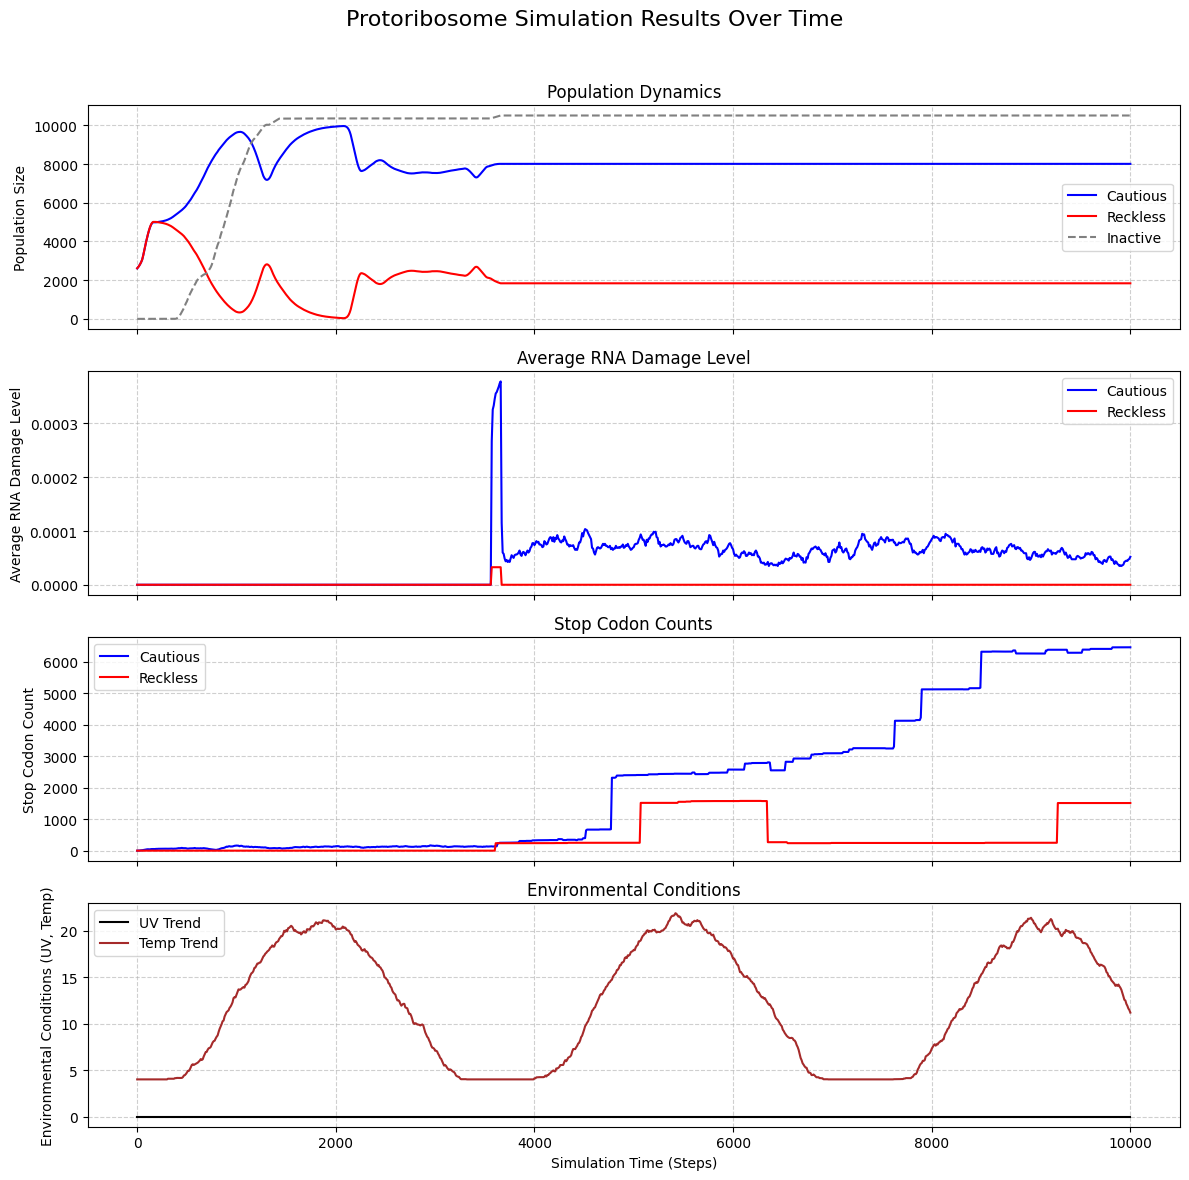

In [ ]:
# Cell TW4QjNqJ55gc: This cell contains the code for plotting the simulation results, including functions to find and load data from checkpoint files within a specific directory.
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import re
import pickle # Import pickle to load checkpoint files

def find_latest_data_file_in_dir(replica_dir):
    """Finds the latest checkpoint file within a specific replica directory."""
    latest_file = None
    latest_time = 0

    # Look for checkpoint files in the replica directory
    checkpoint_files = glob.glob(os.path.join(replica_dir, 'checkpoint_step_*.pkl'))
    for checkpoint_file in checkpoint_files:
         file_time = os.path.getmtime(checkpoint_file)
         if file_time > latest_time:
              latest_time = file_time
              latest_file = checkpoint_file

    # Also check for extinct files
    extinct_files = glob.glob(os.path.join(replica_dir, 'checkpoint_step_*_extinct.pkl'))
    for extinct_file in extinct_files:
         file_time = os.path.getmtime(extinct_file)
         if file_time > latest_time:
              latest_time = file_time
              latest_file = extinct_file

    return latest_file


def load_log_from_checkpoint(file_path):
    """Loads the data_log from a checkpoint file."""
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None

    try:
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
            # Return the 'log' key, which should be the list of dictionaries
            return state.get('log', []) # Return empty list if 'log' key is missing
    except Exception as e:
        print(f"An error occurred while loading the log from {file_path}: {e}")
        return None

# --- Plotting Function ---
def plot_simulation_results(data_df):
    """Plots key simulation metrics over time."""
    if data_df.empty:
        print("No data to plot.")
        return

    # Use the 'time' column for the x-axis
    data_df = data_df.set_index('time')

    # Calculate rolling averages for smoothing, adjust window size based on data length
    rolling_window_size = max(1, len(data_df) // 100) # Use 1% of data points as window, minimum 1
    print(f"Using rolling window size for smoothing: {rolling_window_size}")
    data_smoothed = data_df.rolling(window=rolling_window_size, center=True, min_periods=1).mean()


    # Create 4 subplots instead of 3
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 12), sharex=True) # Changed nrows to 4
    fig.suptitle('Protoribosome Simulation Results Over Time', fontsize=16)

    # Plot 1: Population Dynamics
    axes[0].plot(data_df.index, data_smoothed['cautious'], label='Cautious', color='blue')
    axes[0].plot(data_smoothed.index, data_smoothed['readthrough'], label='Reckless', color='red')
    axes[0].plot(data_smoothed.index, data_smoothed['inactive'], label='Inactive', color='gray', linestyle='--')
    axes[0].set_ylabel('Population Size')
    axes[0].set_title('Population Dynamics')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].set_yscale('linear') # Or 'log' if preferred for large population differences

    # Plot 2: Average Damage Level
    axes[1].plot(data_smoothed.index, data_smoothed['cautious_avg_damage'], label='Cautious', color='blue')
    axes[1].plot(data_smoothed.index, data_smoothed['readthrough_avg_damage'], label='Reckless', color='red')
    axes[1].set_ylabel('Average RNA Damage Level')
    axes[1].set_title('Average RNA Damage Level')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Plot 3: Stop Codon Counts
    axes[2].plot(data_df.index, data_df['cautious_stop_count'], label='Cautious', color='blue')
    axes[2].plot(data_df.index, data_df['readthrough_stop_count'], label='Reckless', color='red')
    axes[2].set_ylabel('Stop Codon Count')
    axes[2].set_title('Stop Codon Counts')
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.6)

    # New Plot 4: Environmental Conditions (UV and Temperature)
    axes[3].plot(data_df.index, data_smoothed['uv'], label='UV Trend', color='black', linestyle='-')
    axes[3].plot(data_df.index, data_smoothed['temp'], label='Temp Trend', color='brown', linestyle='-')
    axes[3].set_ylabel('Environmental Conditions (UV, Temp)')
    axes[3].set_title('Environmental Conditions')
    axes[3].legend()
    axes[3].grid(True, linestyle='--', alpha=0.6)


    # Remove the twin axis from the first plot as UV and Temp are now on a separate plot
    # No need to explicitly remove, just don't create it or add lines to it


    axes[-1].set_xlabel('Simulation Time (Steps)')
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    plt.show()


# --- Main Execution for Plotting ---
# Ensure this matches the simulation cell output for the latest run
BASE_EXPERIMENTS_PATH = '/content/drive/My Drive/Colab Notebooks/Sim_Experiments' # Ensure this matches the simulation cell

# Explicitly define the experiment and replica directory based on simulation output
# Replace with the actual latest directory names from the simulation output if different
latest_experiment_name = 'Experiment_2025-07-05_23-15' # Corrected experiment name
latest_replica_name = 'Replica_1'
target_replica_dir = os.path.join(BASE_EXPERIMENTS_PATH, latest_experiment_name, latest_replica_name)

print(f"Looking for latest simulation data in: {target_replica_dir}...") # Print the target directory

# Use the new function to find the latest checkpoint within the targeted directory
latest_data_file = find_latest_data_file_in_dir(target_replica_dir)


if latest_data_file:
    print(f"Found latest data file: {os.path.basename(latest_data_file)} (from checkpoint)")
    print(f"Loading data from {os.path.basename(latest_data_file)}...")
    # Load the log data from the checkpoint file
    simulation_log_data = load_log_from_checkpoint(latest_data_file)

    if simulation_log_data is not None and simulation_log_data:
        print(f"Successfully loaded log with {len(simulation_log_data)} entries.")
        # Convert the list of dictionaries to a pandas DataFrame
        results_df = pd.DataFrame(simulation_log_data)
        print("Columns in loaded DataFrame:")
        display(results_df.columns.tolist())

        # Ensure 'time' column is present before plotting
        if 'time' in results_df.columns:
             plot_simulation_results(results_df)
        else:
             print("Error: 'time' column not found in the loaded data. Cannot plot.")
    elif simulation_log_data is not None and not simulation_log_data:
         print("Loaded log is empty. No data to plot.")
    else: # simulation_log_data is None
         print("Failed to load simulation log data.")

else:
    print(f"No simulation data files found in the target directory: {target_replica_dir}")

In [ ]:
# Cell JUsiMOSVL7tF: This cell contains functions for finding and loading simulation data from checkpoint files.
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import re
import pickle # Import pickle to load checkpoint files

def find_latest_data_file(base_path):
    """Finds the latest checkpoint file in the experiment directories."""
    latest_file = None
    latest_time = 0

    # Look for experiment directories
    experiment_dirs = sorted(
        [d for d in glob.glob(os.path.join(base_path, 'Experiment_*')) if os.path.isdir(d)],
        key=os.path.getmtime,
        reverse=True
    )

    for exp_dir in experiment_dirs:
        # Look for replica directories within each experiment
        replica_dirs = sorted(
            [d for d in glob.glob(os.path.join(exp_dir, 'Replica_*')) if os.path.isdir(d)],
            key=os.path.getmtime,
            reverse=True
        )
        for rep_dir in replica_dirs:
            # Look for checkpoint files in each replica directory
            checkpoint_files = glob.glob(os.path.join(rep_dir, 'checkpoint_step_*.pkl'))
            for checkpoint_file in checkpoint_files:
                 file_time = os.path.getmtime(checkpoint_file)
                 if file_time > latest_time:
                      latest_time = file_time
                      latest_file = checkpoint_file

            # Also check for extinct files
            extinct_files = glob.glob(os.path.join(rep_dir, 'checkpoint_step_*_extinct.pkl'))
            for extinct_file in extinct_files:
                 file_time = os.path.getmtime(extinct_file)
                 if file_time > latest_time:
                      latest_time = file_time
                      latest_file = extinct_file


    return latest_file

def load_log_from_checkpoint(file_path):
    """Loads the data_log from a checkpoint file."""
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None

    try:
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
            # Return the 'log' key, which should be the list of dictionaries
            return state.get('log', []) # Return empty list if 'log' key is missing
    except Exception as e:
        print(f"An error occurred while loading the log from {file_path}: {e}")
        return None

# --- Plotting Function ---
def plot_simulation_results(data_df):
    """Plots key simulation metrics over time."""
    if data_df.empty:
        print("No data to plot.")
        return

    # Use the 'time' column for the x-axis
    data_df = data_df.set_index('time')

    # Calculate rolling averages for smoothing, adjust window size based on data length
    rolling_window_size = max(1, len(data_df) // 100) # Use 1% of data points as window, minimum 1
    print(f"Using rolling window size for smoothing: {rolling_window_size}")
    data_smoothed = data_df.rolling(window=rolling_window_size, center=True, min_periods=1).mean()


    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)
    fig.suptitle('Protoribosome Simulation Results Over Time', fontsize=16)

    # Plot 1: Population Dynamics
    axes[0].plot(data_df.index, data_df['cautious'], label='Cautious (Raw)', alpha=0.0) # Make raw data invisible
    axes[0].plot(data_df.index, data_smoothed['cautious'], label='Cautious', color='blue')
    axes[0].plot(data_df.index, data_df['readthrough'], label='Reckless (Raw)', alpha=0.0) # Make raw data invisible
    axes[0].plot(data_smoothed.index, data_smoothed['readthrough'], label='Reckless', color='red')
    axes[0].plot(data_df.index, data_df['inactive'], label='Inactive (Raw)', alpha=0.0, linestyle='--') # Make raw data invisible
    axes[0].plot(data_smoothed.index, data_smoothed['inactive'], label='Inactive', color='gray', linestyle='--')
    axes[0].set_ylabel('Population Size')
    axes[0].set_title('Population Dynamics')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].set_yscale('linear') # Or 'log' if preferred for large population differences

    # Plot 2: Average Damage Level
    axes[1].plot(data_df.index, data_df['cautious_avg_damage'], label='Cautious (Raw)', alpha=0.0) # Make raw data invisible
    axes[1].plot(data_df.index, data_smoothed['cautious_avg_damage'], label='Cautious', color='blue')
    axes[1].plot(data_df.index, data_smoothed['readthrough_avg_damage'], label='Reckless (Raw)', alpha=0.0) # Make raw data invisible
    axes[1].plot(data_df.index, data_smoothed['readthrough_avg_damage'], label='Reckless', color='red')
    axes[1].set_ylabel('Average RNA Damage Level')
    axes[1].set_title('Average RNA Damage Level')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Plot 3: Stop Codon Counts
    axes[2].plot(data_df.index, data_df['cautious_stop_count'], label='Cautious', color='blue')
    axes[2].plot(data_df.index, data_df['readthrough_stop_count'], label='Reckless', color='red')
    axes[2].set_ylabel('Stop Codon Count')
    axes[2].set_title('Stop Codon Counts')
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.6)


    # Add a twin axis for Environmental Conditions on the first plot
    ax_env = axes[0].twinx()
    # Plot UV and Temperature on the twin axis
    ax_env.plot(data_df.index, data_df['uv'], label='Daily UV (Raw)', color='gray', alpha=0.0, linestyle='-') # Make raw data invisible
    ax_env.plot(data_df.index, data_smoothed['uv'], label='UV Trend', color='black', linestyle='-')
    ax_env.plot(data_smoothed.index, data_smoothed['temp'], label='Temp Trend', color='brown', linestyle='-')
    ax_env.set_ylabel('Environmental Conditions (UV, Temp)')
    # Combine legends from both axes on the first plot
    lines, labels = axes[0].get_legend_handles_labels()
    lines2, labels2 = ax_env.get_legend_handles_labels()
    axes[0].legend(lines + lines2, labels + labels2, loc='upper left')


    axes[-1].set_xlabel('Simulation Time (Steps)')
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    plt.show()


# --- Main Execution for Plotting ---
BASE_EXPERIMENTS_PATH = '/content/drive/My Drive/Colab Notebooks/Sim_Experiments' # Ensure this matches the simulation cell

print("Looking for latest simulation data...")
latest_data_file = find_latest_data_file(BASE_EXPERIMENTS_PATH)

if latest_data_file:
    print(f"Found latest data file: {os.path.basename(latest_data_file)} (from checkpoint)")
    print(f"Loading data from {os.path.basename(latest_data_file)}...")
    # Load the log data from the checkpoint file
    simulation_log_data = load_log_from_checkpoint(latest_data_file)

    if simulation_log_data is not None and simulation_log_data:
        print(f"Successfully loaded log with {len(simulation_log_data)} entries.")
        # Convert the list of dictionaries to a pandas DataFrame
        results_df = pd.DataFrame(simulation_log_data)
        print("Columns in loaded DataFrame:")
        display(results_df.columns.tolist())

        # Ensure 'time' column is present before plotting
        if 'time' in results_df.columns:
             plot_simulation_results(results_df)
        else:
             print("Error: 'time' column not found in the loaded data. Cannot plot.")
    elif simulation_log_data is not None and not simulation_log_data:
         print("Loaded log is empty. No data to plot.")
    else: # simulation_log_data is None
         print("Failed to load simulation log data.")

else:
    print("No simulation data files found.")

In [ ]:
# Cell 56d8e8f9: This cell contains the code for plotting the simulation results, including functions to find and load data from checkpoint files within a specific directory.
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import re
import pickle # Import pickle to load checkpoint files

def find_latest_data_file_in_dir(replica_dir):
    """Finds the latest checkpoint file within a specific replica directory."""
    latest_file = None
    latest_time = 0

    # Look for checkpoint files in the replica directory
    checkpoint_files = glob.glob(os.path.join(replica_dir, 'checkpoint_step_*.pkl'))
    for checkpoint_file in checkpoint_files:
         file_time = os.path.getmtime(checkpoint_file)
         if file_time > latest_time:
              latest_time = file_time
              latest_file = checkpoint_file

    # Also check for extinct files
    extinct_files = glob.glob(os.path.join(replica_dir, 'checkpoint_step_*_extinct.pkl'))
    for extinct_file in extinct_files:
         file_time = os.path.getmtime(extinct_file)
         if file_time > latest_time:
              latest_time = file_time
              latest_file = extinct_file

    return latest_file


def load_log_from_checkpoint(file_path):
    """Loads the data_log from a checkpoint file."""
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None

    try:
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
            # Return the 'log' key, which should be the list of dictionaries
            return state.get('log', []) # Return empty list if 'log' key is missing
    except Exception as e:
        print(f"An error occurred while loading the log from {file_path}: {e}")
        return None

# --- Plotting Function ---
def plot_simulation_results(data_df):
    """Plots key simulation metrics over time."""
    if data_df.empty:
        print("No data to plot.")
        return

    # Use the 'time' column for the x-axis
    data_df = data_df.set_index('time')

    # Calculate rolling averages for smoothing, adjust window size based on data length
    rolling_window_size = max(1, len(data_df) // 100) # Use 1% of data points as window, minimum 1
    print(f"Using rolling window size for smoothing: {rolling_window_size}")
    data_smoothed = data_df.rolling(window=rolling_window_size, center=True, min_periods=1).mean()


    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)
    fig.suptitle('Protoribosome Simulation Results Over Time', fontsize=16)

    # Plot 1: Population Dynamics
    axes[0].plot(data_df.index, data_df['cautious'], label='Cautious (Raw)', alpha=0.0) # Make raw data invisible
    axes[0].plot(data_df.index, data_smoothed['cautious'], label='Cautious', color='blue')
    axes[0].plot(data_df.index, data_df['readthrough'], label='Reckless (Raw)', alpha=0.0) # Make raw data invisible
    axes[0].plot(data_smoothed.index, data_smoothed['readthrough'], label='Reckless', color='red')
    axes[0].plot(data_df.index, data_df['inactive'], label='Inactive (Raw)', alpha=0.0, linestyle='--') # Make raw data invisible
    axes[0].plot(data_smoothed.index, data_smoothed['inactive'], label='Inactive', color='gray', linestyle='--')
    axes[0].set_ylabel('Population Size')
    axes[0].set_title('Population Dynamics')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].set_yscale('linear') # Or 'log' if preferred for large population differences

    # Plot 2: Average Damage Level
    axes[1].plot(data_df.index, data_df['cautious_avg_damage'], label='Cautious (Raw)', alpha=0.0) # Make raw data invisible
    axes[1].plot(data_df.index, data_smoothed['cautious_avg_damage'], label='Cautious', color='blue')
    axes[1].plot(data_df.index, data_smoothed['readthrough_avg_damage'], label='Reckless (Raw)', alpha=0.0) # Make raw data invisible
    axes[1].plot(data_df.index, data_smoothed['readthrough_avg_damage'], label='Reckless', color='red')
    axes[1].set_ylabel('Average RNA Damage Level')
    axes[1].set_title('Average RNA Damage Level')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Plot 3: Stop Codon Counts
    axes[2].plot(data_df.index, data_df['cautious_stop_count'], label='Cautious', color='blue')
    axes[2].plot(data_df.index, data_df['readthrough_stop_count'], label='Reckless', color='red')
    axes[2].set_ylabel('Stop Codon Count')
    axes[2].set_title('Stop Codon Counts')
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.6)


    # Add a twin axis for Environmental Conditions on the first plot
    ax_env = axes[0].twinx()
    # Plot UV and Temperature on the twin axis
    ax_env.plot(data_df.index, data_df['uv'], label='Daily UV (Raw)', color='gray', alpha=0.0, linestyle='-') # Make raw data invisible
    ax_env.plot(data_df.index, data_smoothed['uv'], label='UV Trend', color='black', linestyle='-')
    ax_env.plot(data_df.index, data_smoothed['temp'], label='Temp Trend', color='brown', linestyle='-')
    ax_env.set_ylabel('Environmental Conditions (UV, Temp)')
    # Combine legends from both axes on the first plot
    lines, labels = axes[0].get_legend_handles_labels()
    lines2, labels2 = ax_env.get_legend_handles_labels()
    axes[0].legend(lines + lines2, labels + labels2, loc='upper left')


    axes[-1].set_xlabel('Simulation Time (Steps)')
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    plt.show()


# --- Main Execution for Plotting ---
# Ensure this matches the simulation cell output for the latest run
BASE_EXPERIMENTS_PATH = '/content/drive/My Drive/Colab Notebooks/Sim_Experiments' # Ensure this matches the simulation cell

# Explicitly define the experiment and replica directory based on simulation output
# Replace with the actual latest directory names from the simulation output if different
latest_experiment_name = 'Experiment_2025-07-05_23-15' # Corrected experiment name
latest_replica_name = 'Replica_1'
target_replica_dir = os.path.join(BASE_EXPERIMENTS_PATH, latest_experiment_name, latest_replica_name)

print(f"Looking for latest simulation data in: {target_replica_dir}...") # Print the target directory

# Use the new function to find the latest checkpoint within the targeted directory
latest_data_file = find_latest_data_file_in_dir(target_replica_dir)


if latest_data_file:
    print(f"Found latest data file: {os.path.basename(latest_data_file)} (from checkpoint)")
    print(f"Loading data from {os.path.basename(latest_data_file)}...")
    # Load the log data from the checkpoint file
    simulation_log_data = load_log_from_checkpoint(latest_data_file)

    if simulation_log_data is not None and simulation_log_data:
        print(f"Successfully loaded log with {len(simulation_log_data)} entries.")
        # Convert the list of dictionaries to a pandas DataFrame
        results_df = pd.DataFrame(simulation_log_data)
        print("Columns in loaded DataFrame:")
        display(results_df.columns.tolist())

        # Ensure 'time' column is present before plotting
        if 'time' in results_df.columns:
             plot_simulation_results(results_df)
        else:
             print("Error: 'time' column not found in the loaded data. Cannot plot.")
    elif simulation_log_data is not None and not simulation_log_data:
         print("Loaded log is empty. No data to plot.")
    else: # simulation_log_data is None
         print("Failed to load simulation log data.")

else:
    print(f"No simulation data files found in the target directory: {target_replica_dir}")

In [ ]:
# Re-run the plotting cell to visualize the results of the new simulation run.
# This cell is a copy of the plotting cell (TW4QjNqJ55gc) but is regenerated here
# to ensure it picks up the latest simulation data saved by the orchestrator.

import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import re
import pickle # Import pickle to load checkpoint files

def find_latest_data_file_in_dir(replica_dir):
    """Finds the latest checkpoint file within a specific replica directory."""
    latest_file = None
    latest_time = 0

    # Look for checkpoint files in the replica directory
    checkpoint_files = glob.glob(os.path.join(replica_dir, 'checkpoint_step_*.pkl'))
    for checkpoint_file in checkpoint_files:
         file_time = os.path.getmtime(checkpoint_file)
         if file_time > latest_time:
              latest_time = file_time
              latest_file = checkpoint_file

    # Also check for extinct files
    extinct_files = glob.glob(os.path.join(replica_dir, 'checkpoint_step_*_extinct.pkl'))
    for extinct_file in extinct_files:
         file_time = os.path.getmtime(extinct_file)
         if file_time > latest_time:
              latest_time = file_time
              latest_file = extinct_file

    return latest_file


def load_log_from_checkpoint(file_path):
    """Loads the data_log from a checkpoint file."""
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None

    try:
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
            # Return the 'log' key, which should be the list of dictionaries
            return state.get('log', []) # Return empty list if 'log' key is missing
    except Exception as e:
        print(f"An error occurred while loading the log from {file_path}: {e}")
        return None

# --- Plotting Function ---
def plot_simulation_results(data_df):
    """Plots key simulation metrics over time."""
    if data_df.empty:
        print("No data to plot.")
        return

    # Use the 'time' column for the x-axis
    data_df = data_df.set_index('time')

    # Calculate rolling averages for smoothing, adjust window size based on data length
    rolling_window_size = max(1, len(data_df) // 100) # Use 1% of data points as window, minimum 1
    print(f"Using rolling window size for smoothing: {rolling_window_size}")
    data_smoothed = data_df.rolling(window=rolling_window_size, center=True, min_periods=1).mean()


    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)
    fig.suptitle('Protoribosome Simulation Results Over Time', fontsize=16)

    # Plot 1: Population Dynamics
    axes[0].plot(data_df.index, data_df['cautious'], label='Cautious (Raw)', alpha=0.0) # Make raw data invisible
    axes[0].plot(data_df.index, data_smoothed['cautious'], label='Cautious', color='blue')
    axes[0].plot(data_df.index, data_df['readthrough'], label='Reckless (Raw)', alpha=0.0) # Make raw data invisible
    axes[0].plot(data_smoothed.index, data_smoothed['readthrough'], label='Reckless', color='red')
    axes[0].plot(data_df.index, data_df['inactive'], label='Inactive (Raw)', alpha=0.0, linestyle='--') # Make raw data invisible
    axes[0].plot(data_smoothed.index, data_smoothed['inactive'], label='Inactive', color='gray', linestyle='--')
    axes[0].set_ylabel('Population Size')
    axes[0].set_title('Population Dynamics')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].set_yscale('linear') # Or 'log' if preferred for large population differences

    # Plot 2: Average Damage Level
    axes[1].plot(data_df.index, data_df['cautious_avg_damage'], label='Cautious (Raw)', alpha=0.0) # Make raw data invisible
    axes[1].plot(data_df.index, data_smoothed['cautious_avg_damage'], label='Cautious', color='blue')
    axes[1].plot(data_df.index, data_smoothed['readthrough_avg_damage'], label='Reckless (Raw)', alpha=0.0) # Make raw data invisible
    axes[1].plot(data_df.index, data_smoothed['readthrough_avg_damage'], label='Reckless', color='red')
    axes[1].set_ylabel('Average RNA Damage Level')
    axes[1].set_title('Average RNA Damage Level')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Plot 3: Stop Codon Counts
    axes[2].plot(data_df.index, data_df['cautious_stop_count'], label='Cautious', color='blue')
    axes[2].plot(data_df.index, data_df['readthrough_stop_count'], label='Reckless', color='red')
    axes[2].set_ylabel('Stop Codon Count')
    axes[2].set_title('Stop Codon Counts')
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.6)


    # Add a twin axis for Environmental Conditions on the first plot
    ax_env = axes[0].twinx()
    # Plot UV and Temperature on the twin axis
    ax_env.plot(data_df.index, data_df['uv'], label='Daily UV (Raw)', color='gray', alpha=0.0, linestyle='-') # Make raw data invisible
    ax_env.plot(data_df.index, data_smoothed['uv'], label='UV Trend', color='black', linestyle='-')
    ax_env.plot(data_df.index, data_smoothed['temp'], label='Temp Trend', color='brown', linestyle='-')
    ax_env.set_ylabel('Environmental Conditions (UV, Temp)')
    # Combine legends from both axes on the first plot
    lines, labels = axes[0].get_legend_handles_labels()
    lines2, labels2 = ax_env.get_legend_handles_labels()
    axes[0].legend(lines + lines2, labels + labels2, loc='upper left')


    axes[-1].set_xlabel('Simulation Time (Steps)')
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    plt.show()


# --- Main Execution for Plotting ---
# Ensure this matches the simulation cell output for the latest run
BASE_EXPERIMENTS_PATH = '/content/drive/My Drive/Colab Notebooks/Sim_Experiments' # Ensure this matches the simulation cell

# Explicitly define the experiment and replica directory based on simulation output
# Find the latest experiment directory created by the simulation
experiment_dirs = sorted(
    [d for d in glob.glob(os.path.join(BASE_EXPERIMENTS_PATH, 'Experiment_*')) if os.path.isdir(d)],
    key=os.path.getmtime,
    reverse=True
)

latest_experiment_name = None
if experiment_dirs:
    latest_experiment_name = os.path.basename(experiment_dirs[0])

# Find the latest replica directory within that experiment
latest_replica_name = None
if latest_experiment_name:
    replica_dirs_in_exp = sorted(
        [d for d in glob.glob(os.path.join(BASE_EXPERIMENTS_PATH, latest_experiment_name, 'Replica_*')) if os.path.isdir(d)],
        key=os.path.getmtime,
        reverse=True
    )
    if replica_dirs_in_exp:
        latest_replica_name = os.path.basename(replica_dirs_in_exp[0])


if latest_experiment_name and latest_replica_name:
    target_replica_dir = os.path.join(BASE_EXPERIMENTS_PATH, latest_experiment_name, latest_replica_name)
    print(f"Looking for latest simulation data in: {target_replica_dir}...") # Print the target directory

    # Use the new function to find the latest checkpoint within the targeted directory
    latest_data_file = find_latest_data_file_in_dir(target_replica_dir)


    if latest_data_file:
        print(f"Found latest data file: {os.path.basename(latest_data_file)} (from checkpoint)")
        print(f"Loading data from {os.path.basename(latest_data_file)}...")
        # Load the log data from the checkpoint file
        simulation_log_data = load_log_from_checkpoint(latest_data_file)

        if simulation_log_data is not None and simulation_log_data:
            print(f"Successfully loaded log with {len(simulation_log_data)} entries.")
            # Convert the list of dictionaries to a pandas DataFrame
            results_df = pd.DataFrame(simulation_log_data)
            print("Columns in loaded DataFrame:")
            display(results_df.columns.tolist())

            # Ensure 'time' column is present before plotting
            if 'time' in results_df.columns:
                 plot_simulation_results(results_df)
            else:
                 print("Error: 'time' column not found in the loaded data. Cannot plot.")
        elif simulation_log_data is not None and not simulation_log_data:
             print("Loaded log is empty. No data to plot.")
        else: # simulation_log_data is None
             print("Failed to load simulation log data.")

    else:
        print(f"No simulation data files found in the target directory: {target_replica_dir}")

else:
    print("Could not determine the latest experiment or replica directory.")

Could not determine the latest experiment or replica directory.
